In [2]:
# 0. 사용할 패키지 불러오기
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

from math import sqrt

np.random.seed(5)


# 1. 데이터셋 생성하기
signal_data = pd.read_csv('price_pear_D.csv', engine='python', encoding='ms949')
data = signal_data.values
retail_price = data

#std = np.std(df[‘retail_price’].values)

#create_ dataset
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 1:])
        dataY.append(signal_data[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

look_back = 7

#2. 데이터셋 분할
X, Y = create_dataset(data, look_back)

In [3]:
Y

array([31530., 31530., 31530., ..., 23000., 25000., 25000.])

In [4]:
train_stats = signal_data.describe()
train_stats.pop("date")
train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
mean(°C),1422.0,13.621449,10.897694,-14.8,4.5,15.05,23.00,33.7
prep(mm),1422.0,3.075879,11.870504,0.0,0.0,0.00,0.20,144.5
humidity(%),1422.0,57.805626,14.828366,21.8,46.8,57.80,67.75,97.0
whole_price,1422.0,44195.857947,9414.533573,30000.0,37000.0,40000.00,50000.00,75000.0
retail_price,1422.0,32142.514768,7373.776092,19980.0,26647.0,30665.00,37330.00,51500.0


In [5]:
rtp = retail_price[:,-1]
print(rtp)

[30665. 31530. 31530. ... 23000. 25000. 25000.]


In [6]:
std = np.std(rtp)
print(std)

7371.18288818149


### create dataset을 수행한 뒤 데이터 분할

In [7]:
signal_data.shape

(1422, 6)

In [8]:
# 데이터셋 생성
x_train = X[0:850,]
y_train = Y[0:850,] 

x_val = X[850:1100]
y_val = Y[850:1100]

x_test = X[1100:,]
y_test = Y[1100:,]
y_test_var = y_test


In [9]:
# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(7, 5), activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(1))

#3. 모델 아키텍쳐 살펴보기
# model.summary()

# 4. 모델 학습과정 설정하기
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
#model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [10]:
#5.모델 학습시키기
#5.1. Early Stopping
callbacks_list = [
    EarlyStopping(
    monitor='val_loss',
    patience=20 ,
    ),
#     ModelCheckpoint(
#     filepath='multi_model.h5',
#     monitor='val_loss',
#     save_best_only = True,
#     )
]


In [11]:
# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=30, batch_size=16, callbacks=callbacks_list, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 850 samples, validate on 250 samples
Epoch 1/30





850/850 [==============================] - 4s 5ms/step - loss: 637318495.3224 - mean_absolute_error: 23478.7459 - val_loss: 525654076.3700 - val_mean_absolute_error: 17132.0541
Epoch 2/30
850/850 [==============================] - 1s 1ms/step - loss: 328203809.3741 - mean_absolute_error: 14758.5675 - val_loss: 121142316.3520 - val_mean_absolute_error: 7978.8372
Epoch 3/30
850/850 [==============================] - 1s 1ms/step - loss: 59559710.9082 - mean_absolute_error: 6115.3551 - val_loss: 74983499.0080 - val_mean_absolute_error: 6348.0282
Epoch 4/30
850/850 [==============================] - 1s 1ms/step - loss: 56165423.3812 - mean_absolute_error: 5383.1697 - val_loss: 55535669.9840 - val_mean_absolute_error: 5092.5668
Epoch 5/30
850/850 [==============================] - 1s 1ms/step - loss: 54887750.4753 - mean_absolute_error

In [12]:
# 6. 모델 평가하기
scores = model.evaluate(x_test, y_test)
print("%s: %.2f" %(model.metrics_names[1], scores[1]))

315/315 [==============================] - 0s 159us/step
mean_absolute_error: 3384.56


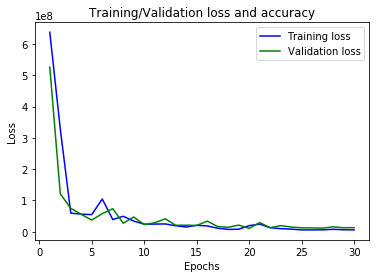

In [15]:
# 6.1. 학습과정 살펴보기
#epoch, loss 그래프
loss = hist.history['loss']
val_loss = hist.history['val_loss']


epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')

plt.title('Training/Validation loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# 6.2. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  [6259087.77117647, 1877.1113370289522]
Validataion Score:  [13184577.62, 2408.6107919921874]
Test Score:  [20385186.953968253, 3384.5550207713295]


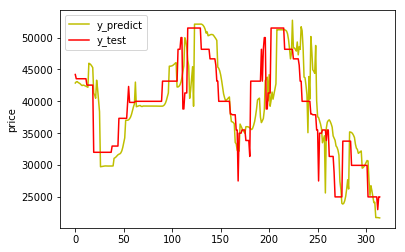

In [17]:
def show_diff(y_predict, y_label, y_test, y_test_label, y_value):

    fig, predict_ax=plt.subplots()

    predict_ax.plot(y_predict, 'y', label=y_label)

    predict_ax.plot(y_test, 'r', label=y_test_label)

    predict_ax.set_ylabel(y_value)

    predict_ax.legend(loc = 'upper left')

    plt.show()
    
#7 예측하기

y_predict = model.predict(x_test).flatten()

show_diff(y_predict, 'y_predict', y_test, 'y_test', 'price')

In [18]:
# 데이터 저장
df = pd.DataFrame(y_predict)
df.insert(0,'y_test',y_test_var)
df = df.rename(columns = {0: 'y_predict'})
df.to_csv('predict_000.csv', index=False)

# df = pd.DataFrame(result)
# df.insert(0,'Y_test',Y_test_var)
# df = df.rename(columns = {0: 'Y_predict'})
# df.to_csv("predict_multinomial.csv", index=False)   

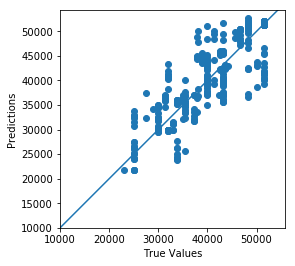

In [19]:

test_predictions = y_test

plt.scatter(y_test, y_predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([10000,plt.xlim()[1]])
plt.ylim([10000,plt.ylim()[1]])
_ = plt.plot([-100000, 100000], [-100000, 100000])

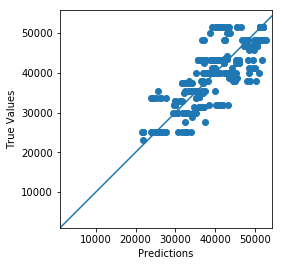

In [20]:
test_predictions = y_test

plt.scatter(y_predict, y_test)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([1000,plt.xlim()[1]])
plt.ylim([1000,plt.ylim()[1]])
_ = plt.plot([-100000, 100000], [-100000, 100000])

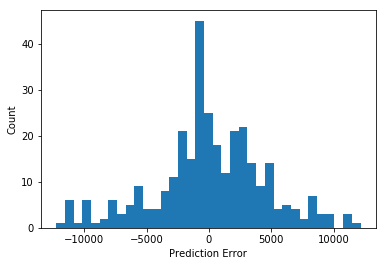

In [21]:
#오차의 분포
error = y_predict - y_test
plt.hist(error, bins = 35)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [22]:
rmse = sqrt(mean_squared_error(y_predict,y_test))
print("RMSE: {:.2f}".format(rmse))

RMSE: 4515.00


In [23]:
print("STD: {:.2f}".format(std))

STD: 7371.18
